### Globale Parameter und Setup

In [126]:
# Globale Parameter
INTERVAL = "15m"  # Zeitintervall der Daten
DAYS = 180  # Historische Tage
RSI_THRESHOLD = 30  # Einstiegsschwelle für RSI
TAKE_PROFIT = 0.03  # Take-Profit in Prozent
STOP_LOSS = 0.01  # Stop-Loss in Prozent
TRAILING_STOP = 0.02  # Trailing Stop-Loss
COINS = ["BTCUSDT", "ETHUSDT", "XRPUSDT"]  # Zu analysierende Coins

### Import der benötigten Bibliotheken

In [127]:
# Importieren der notwendigen Bibliotheken
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import warnings

# Warnungen deaktivieren
warnings.filterwarnings("ignore")

# Matplotlib für Jupyter-Notebooks konfigurieren
%matplotlib inline

print("Alle Module erfolgreich geladen.")

Alle Module erfolgreich geladen.


### Lokale Speicherung/Laden

In [128]:
import os
import pandas as pd

# Ordner für die historischen Daten
HISTORICAL_DATA_PATH = r"C:\Projects\chart analyse\historical_data"

def ensure_directory_exists(path):
    """
    Stellt sicher, dass das angegebene Verzeichnis existiert.
    """
    if not os.path.exists(path):
        os.makedirs(path)

def save_historical_data(data, file_name):
    """
    Speichert ein DataFrame mit historischen Daten als CSV-Datei.
    
    Parameters:
        data (pd.DataFrame): Historische Daten, die gespeichert werden sollen.
        file_name (str): Name der CSV-Datei (z. B. BTCUSDT_15m.csv).
    """
    file_path = os.path.join(HISTORICAL_DATA_PATH, file_name)
    ensure_directory_exists(HISTORICAL_DATA_PATH)
    data.to_csv(file_path, index=False)
    print(f"Datei gespeichert: {file_path}")

def load_historical_data(file_name):
    """
    Lädt historische Daten aus einer CSV-Datei.
    
    Parameters:
        file_name (str): Name der CSV-Datei (z. B. BTCUSDT_15m.csv).
    
    Returns:
        pd.DataFrame: Geladene Daten oder None, falls die Datei nicht existiert.
    """
    file_path = os.path.join(HISTORICAL_DATA_PATH, file_name)
    print(f"Versuche, Daten aus folgendem Pfad zu laden: {file_path}")
    if os.path.exists(file_path):
        print(f"Datei gefunden: {file_path}")
        return pd.read_csv(file_path)
    else:
        print(f"Datei nicht gefunden: {file_path}")
        return None

def fetch_or_load_historical_data(fetch_function, symbol, interval="15m", days=180):
    """
    Lädt historische Daten aus einer Datei oder ruft sie ab, falls die Datei nicht existiert.
    
    Parameters:
        fetch_function (function): Funktion, die historische Daten abruft.
        symbol (str): Das Handelspaar (z. B. BTCUSDT).
        interval (str): Zeitintervall (z. B. 15m, 1h).
        days (int): Anzahl der Tage, für die Daten abgerufen werden sollen.
    
    Returns:
        pd.DataFrame: Historische Daten.
    """
    file_name = f"{symbol}_{interval}.csv"
    data = load_historical_data(file_name)
    if data is None or data.empty:
        print(f"Daten für {symbol} nicht gefunden. Abrufen von der API...")
        data = fetch_function(symbol, interval, days)
        if data is not None and not data.empty:
            save_historical_data(data, file_name)
    else:
        print(f"Daten erfolgreich aus {file_name} geladen.")
    return data


### Datenabruf und Speicherung

In [129]:
def fetch_top_10_coins():
    """
    Fetches the top 10 coins by market cap from CoinGecko and excludes blacklisted pairs.
    """
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": 10,
        "page": 1,
        "sparkline": False
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()

        # Blacklist for unwanted pairs
        blacklist = ["USDT", "stETH"]

        # Filter coins: exclude symbols in blacklist
        coins = [
            {"Symbol": coin["symbol"].upper(), "Name": coin["name"], "Market Cap": coin["market_cap"]}
            for coin in data if coin["symbol"].upper() not in blacklist
        ]

        df = pd.DataFrame(coins)
        
        # Ausgabe der Top 10 Coins
        print_top_10_coins(df)
        
        return df
    else:
        print("Fehler beim Abrufen der Daten:", response.status_code)
        return None

def print_top_10_coins(df):
    """
    Prints the top 10 coins in a tabular format.
    """
    print("\nTop 10 Coins by Market Cap:")
    print(df.to_string(index=False))

# Abrufen und Ausgabe der Daten
df_top_10 = fetch_top_10_coins()



Top 10 Coins by Market Cap:
Symbol              Name    Market Cap
   BTC           Bitcoin 1964902148103
   ETH          Ethereum  464304281577
   XRP               XRP  132389628762
   SOL            Solana  111263069955
   BNB               BNB  104489808805
  DOGE          Dogecoin   63802391910
   ADA           Cardano   42539239154
  USDC              USDC   40261508876
 STETH Lido Staked Ether   37960315174


In [130]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_historical_data_complete(symbol, interval="15m", days=180):
    """
    Holt historische Daten von Binance und erstellt einen DataFrame.
    """
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(pd.Timestamp.now().timestamp() * 1000)
    start_time = int((pd.Timestamp.now() - pd.Timedelta(days=days)).timestamp() * 1000)

    all_data = []
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000,
        }
        response = requests.get(base_url, params=params)
        if response.status_code != 200:
            print(f"Fehler beim Abrufen der Daten für {symbol}. Status: {response.status_code}")
            break
        
        data = response.json()
        if not data:
            print(f"Keine weiteren Daten für {symbol}.")
            break
        
        all_data.extend(data)
        start_time = data[-1][0] + 1

    if not all_data:
        print(f"Keine Daten für {symbol} verfügbar.")
        return pd.DataFrame()  # Leerer DataFrame
    
    df = pd.DataFrame(all_data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")

      # Konvertiere numerische Spalten in float
    numeric_columns = ["Open", "High", "Low", "Close", "Volume"]
    df[numeric_columns] = df[numeric_columns].astype(float)

    # Umbenennen der Spalten in Kleinbuchstaben
    df = df.rename(columns=str.lower)
    
    print("Spalten im DataFrame:", df.columns)  # Debugging
    return df[["open time", "close", "high", "low", "volume"]]

def fetch_or_load_historical_data(fetch_function, symbol, interval="15m", days=180):
    file_name = f"{symbol}_{interval}.csv"

    try:
        df = pd.read_csv(file_name)
        print(f"Daten lokal geladen: {file_name}")
    except FileNotFoundError:
        print("Lokale Daten nicht verfügbar. Abrufen...")
        df = fetch_function(symbol, interval, days)
        if not df.empty:
            df.to_csv(file_name, index=False)
            print(f"Daten gespeichert: {file_name}")
    return df


# Testaufruf
print(fetch_historical_data_complete("BTCUSDT", "15m", 180).head())




Keine weiteren Daten für BTCUSDT.
Spalten im DataFrame: Index(['open time', 'open', 'high', 'low', 'close', 'volume', 'close time',
       'quote asset volume', 'number of trades', 'taker buy base volume',
       'taker buy quote asset volume', 'ignore'],
      dtype='object')
            open time     close      high       low    volume
0 2024-06-08 23:00:00  69325.70  69340.00  69314.01  60.79806
1 2024-06-08 23:15:00  69303.38  69325.71  69293.54  58.80618
2 2024-06-08 23:30:00  69335.13  69335.13  69292.99  73.23727
3 2024-06-08 23:45:00  69310.46  69335.13  69307.40  60.88325
4 2024-06-09 00:00:00  69300.00  69310.46  69291.30  65.11526


### Berechnung der technischen Indikatoren

In [131]:
import pandas as pd
import ta


def calculate_indicators(data: pd.DataFrame) -> pd.DataFrame:
    """
    Berechnet technische Indikatoren (RSI, MACD, Bollinger Bands) und entfernt NaN-Werte.
    """
    # Sicherstellen, dass die erforderlichen Spalten vorhanden sind
    required_columns = ['close', 'high', 'low', 'volume']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Die erforderliche Spalte '{col}' fehlt in den Daten.")
    
    # RSI
    data['RSI'] = ta.momentum.RSIIndicator(close=data['close'], window=14).rsi()
    
    # MACD
    macd = ta.trend.MACD(close=data['close'], window_slow=26, window_fast=12, window_sign=9)
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    data['MACD_Hist'] = macd.macd_diff()
    
    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close=data['close'], window=20, window_dev=2)
    data['BB_Upper'] = bb.bollinger_hband()
    data['BB_Lower'] = bb.bollinger_lband()
    data['BB_Middle'] = bb.bollinger_mavg()
    
    # Entfernen der NaN-Werte
    data = data.dropna().reset_index(drop=True)
    
    return data


if __name__ == "__main__":
    # Prüfen, ob die Funktion `fetch_historical_data_complete` definiert ist
    if 'fetch_historical_data_complete' not in globals():
        raise NameError("Die Funktion `fetch_historical_data_complete` ist nicht definiert.")

    # Liste der Coins, die analysiert werden sollen
    coin_list = ["BTCUSDT", "ETHUSDT", "XRPUSDT","BNBUSDT","ADAUSDT","SOLUSDT","DOGEUSDT"]  # Beliebig erweiterbar
    interval = "15m"
    days = 180

    # Initialisiere das DataDict
    data_dict = {}

    # Historische Daten für jeden Coin abrufen und Indikatoren berechnen
    for symbol in coin_list:
        print(f"Abfrage historischer Daten für {symbol}...")
        historical_data = fetch_historical_data_complete(symbol=symbol, interval=interval, days=days)

        if historical_data is None or historical_data.empty:
            print(f"Keine historischen Daten für {symbol} verfügbar. Überspringe...")
            continue

        print(f"Daten erfolgreich abgerufen: {len(historical_data)} Zeilen für {symbol}.")
        print(historical_data.head())  # Zeigt die ersten Zeilen

        # Indikatoren berechnen
        try:
            df_with_indicators = calculate_indicators(historical_data)
            data_dict[symbol] = df_with_indicators
            print(f"Indikatoren für {symbol} erfolgreich berechnet.")
        except ValueError as e:
            print(f"Fehler bei der Indikatorberechnung für {symbol}: {e}")

    # Überprüfen, ob das `data_dict` Daten enthält
    if not data_dict:
        print("Keine Daten für die angegebenen Coins verfügbar.")
    else:
        print(f"DataDict enthält die folgenden Coins: {list(data_dict.keys())}")


Abfrage historischer Daten für BTCUSDT...
Keine weiteren Daten für BTCUSDT.
Spalten im DataFrame: Index(['open time', 'open', 'high', 'low', 'close', 'volume', 'close time',
       'quote asset volume', 'number of trades', 'taker buy base volume',
       'taker buy quote asset volume', 'ignore'],
      dtype='object')
Daten erfolgreich abgerufen: 17276 Zeilen für BTCUSDT.
            open time     close      high       low    volume
0 2024-06-08 23:00:00  69325.70  69340.00  69314.01  60.79806
1 2024-06-08 23:15:00  69303.38  69325.71  69293.54  58.80618
2 2024-06-08 23:30:00  69335.13  69335.13  69292.99  73.23727
3 2024-06-08 23:45:00  69310.46  69335.13  69307.40  60.88325
4 2024-06-09 00:00:00  69300.00  69310.46  69291.30  65.11526
Indikatoren für BTCUSDT erfolgreich berechnet.
Abfrage historischer Daten für ETHUSDT...
Keine weiteren Daten für ETHUSDT.
Spalten im DataFrame: Index(['open time', 'open', 'high', 'low', 'close', 'volume', 'close time',
       'quote asset volume', 'nu

### Backtesting-Logik / Performance berechnung / Visalsierung der trades

Processing BTCUSDT...
Visualizing trades for BTCUSDT...


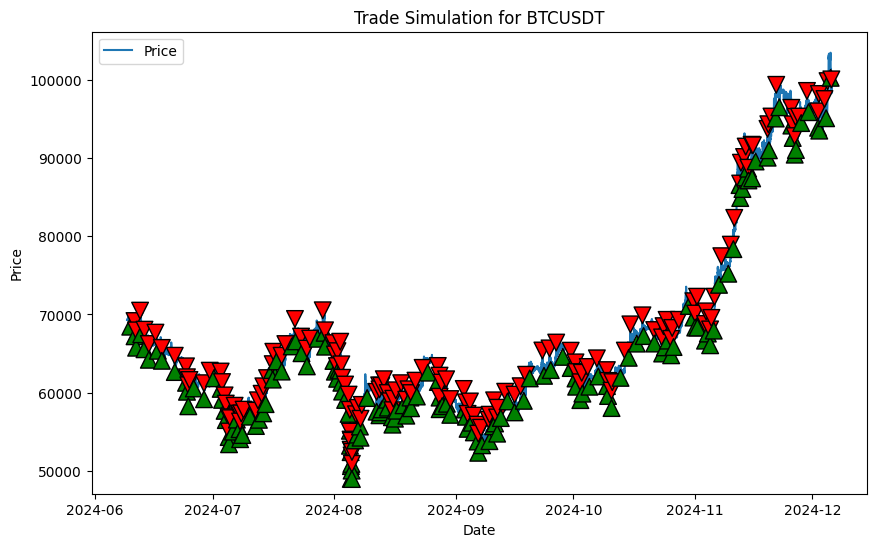

Buy/Sell Signals for BTCUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 00:15,69500.0000,2024-06-11 02:30,68084.5000,-1415.5000
2024-06-11 02:45,68268.6200,2024-06-11 11:45,66890.0100,-1378.6100
2024-06-11 12:15,66807.4800,2024-06-12 12:30,69417.9900,2610.5100
2024-06-12 19:15,68530.4600,2024-06-13 15:15,66980.0200,-1550.4400
2024-06-13 15:30,66608.0100,2024-06-14 18:00,65144.0100,-1464.0000
2024-06-14 18:15,65264.1700,2024-06-16 10:30,66600.0100,1335.8400
2024-06-17 01:15,66414.0100,2024-06-18 01:30,64641.7100,-1772.3000
2024-06-18 01:45,65133.9900,2024-06-21 08:45,63639.6400,-1494.3500
2024-06-21 09:00,63694.0200,2024-06-24 05:30,62283.2500,-1410.7700
2024-06-24 05:45,62314.0100,2024-06-24 11:15,60887.1300,-1426.8800


Visualizing RSI for BTCUSDT...


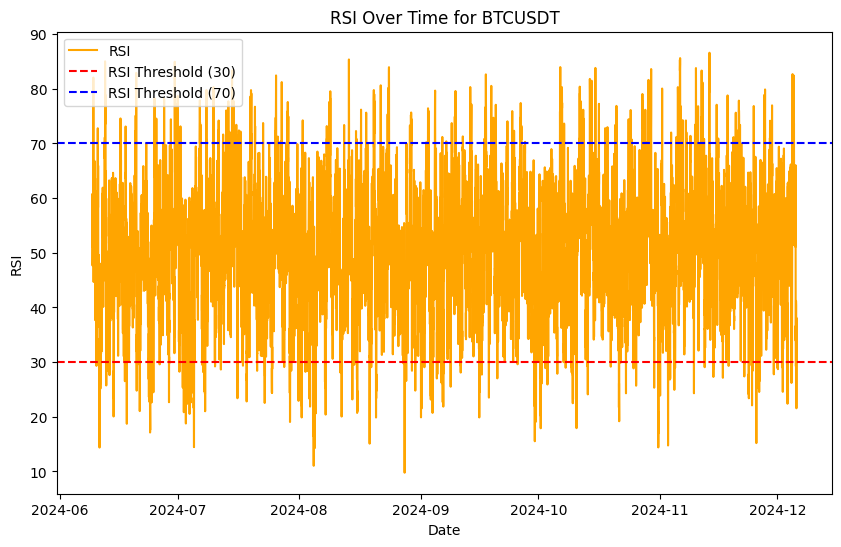

Processing ETHUSDT...
Visualizing trades for ETHUSDT...


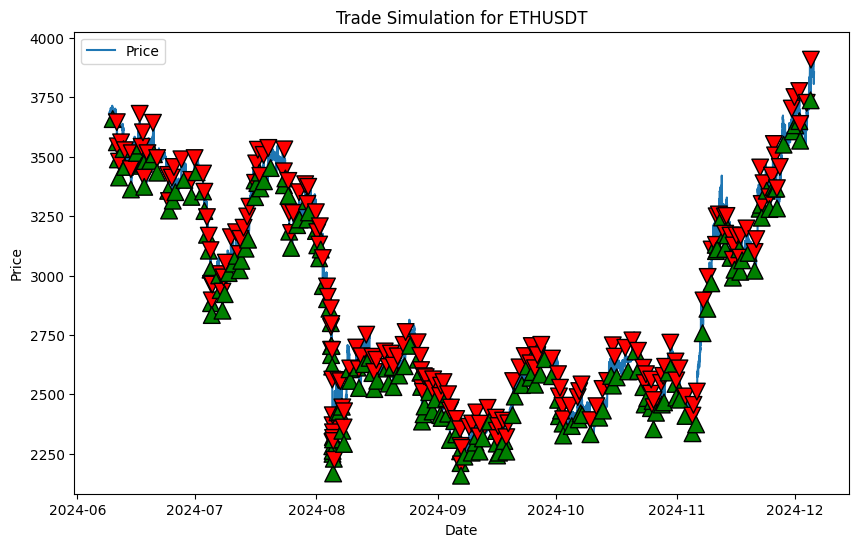

Buy/Sell Signals for ETHUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 00:45,3693.5300,2024-06-11 02:00,3610.1900,-83.3400
2024-06-11 02:15,3595.8400,2024-06-11 08:00,3508.3900,-87.4500
2024-06-11 08:15,3523.8200,2024-06-11 15:30,3444.2400,-79.5800
2024-06-11 15:45,3447.7500,2024-06-12 04:00,3525.3800,77.6300
2024-06-12 18:45,3567.1500,2024-06-13 03:15,3492.4000,-74.7500
2024-06-13 03:30,3492.2100,2024-06-14 16:00,3412.8300,-79.3800
2024-06-14 16:15,3397.4000,2024-06-14 21:15,3479.5500,82.1500
2024-06-16 04:00,3551.1600,2024-06-16 22:00,3645.5100,94.3500
2024-06-17 03:45,3582.0500,2024-06-17 10:00,3506.5800,-75.4700
2024-06-17 10:15,3496.8200,2024-06-17 18:00,3567.6000,70.7800


Visualizing RSI for ETHUSDT...


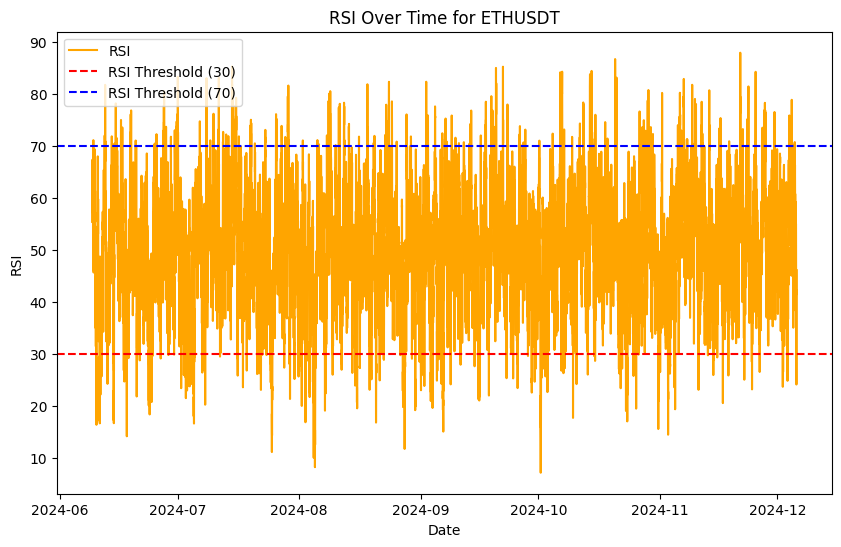

Processing XRPUSDT...
Visualizing trades for XRPUSDT...


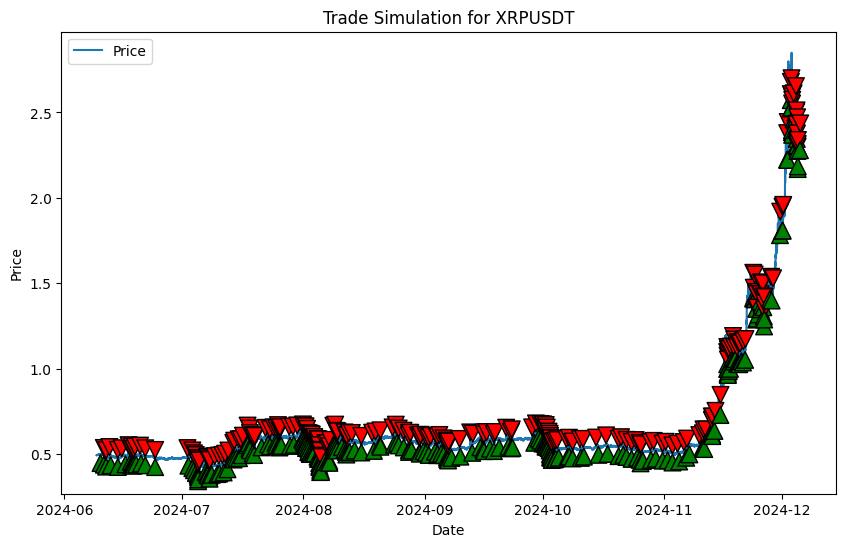

Buy/Sell Signals for XRPUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 05:45,0.4972,2024-06-11 02:15,0.4860,-0.0112
2024-06-11 02:30,0.4877,2024-06-11 15:30,0.4730,-0.0147
2024-06-11 15:45,0.4765,2024-06-12 12:30,0.4915,0.0150
2024-06-12 19:45,0.4844,2024-06-14 15:30,0.4745,-0.0099
2024-06-14 15:45,0.4743,2024-06-15 15:00,0.4842,0.0099
2024-06-16 14:15,0.4899,2024-06-17 09:15,0.5023,0.0124
2024-06-17 23:00,0.5045,2024-06-18 01:30,0.4788,-0.0257
2024-06-18 01:45,0.4835,2024-06-18 05:00,0.4942,0.0107
2024-06-18 12:30,0.4918,2024-06-18 16:00,0.4804,-0.0114
2024-06-18 16:15,0.4818,2024-06-19 00:30,0.4936,0.0118


Visualizing RSI for XRPUSDT...


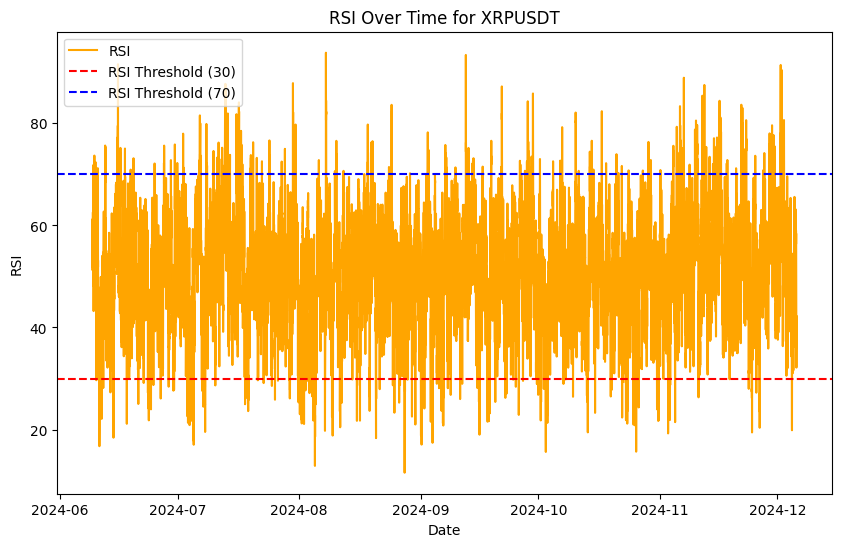

Processing SOLUSDT...
Visualizing trades for SOLUSDT...


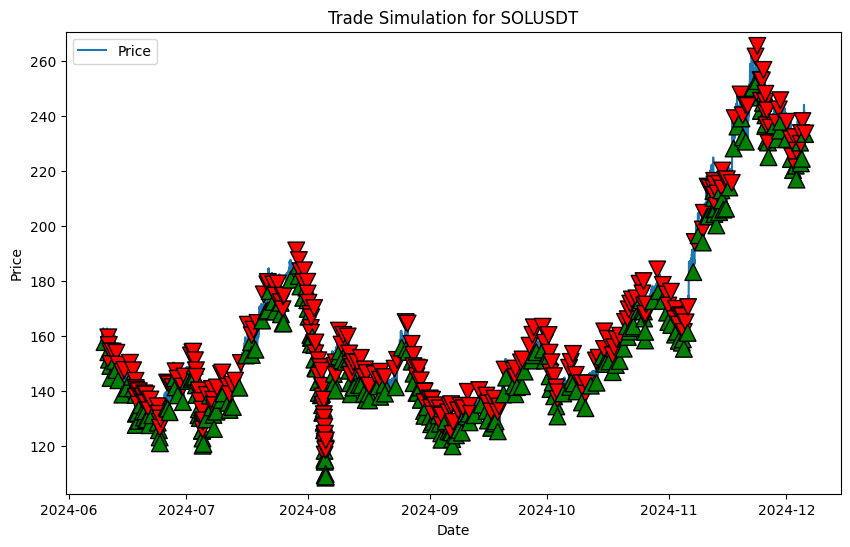

Buy/Sell Signals for SOLUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 03:00,160.7400,2024-06-11 01:45,156.3900,-4.3500
2024-06-11 02:00,157.0500,2024-06-11 05:30,153.6200,-3.4300
2024-06-11 05:45,154.3300,2024-06-11 13:45,151.2400,-3.0900
2024-06-11 14:15,152.0500,2024-06-11 15:30,146.6600,-5.3900
2024-06-11 15:45,147.6700,2024-06-12 04:15,151.2100,3.5400
2024-06-12 19:30,153.8500,2024-06-13 03:00,150.7700,-3.0800
2024-06-13 03:15,150.5500,2024-06-13 15:30,146.5000,-4.0500
2024-06-13 15:45,146.8700,2024-06-14 15:45,143.7800,-3.0900
2024-06-14 16:00,141.6300,2024-06-15 03:30,144.5400,2.9100
2024-06-15 20:15,143.9600,2024-06-16 15:00,147.1300,3.1700


Visualizing RSI for SOLUSDT...


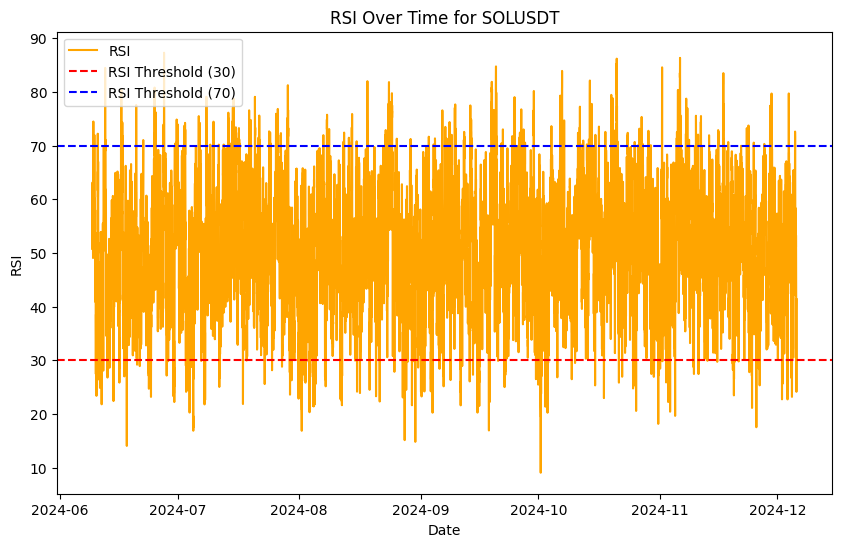

Processing BNBUSDT...
Visualizing trades for BNBUSDT...


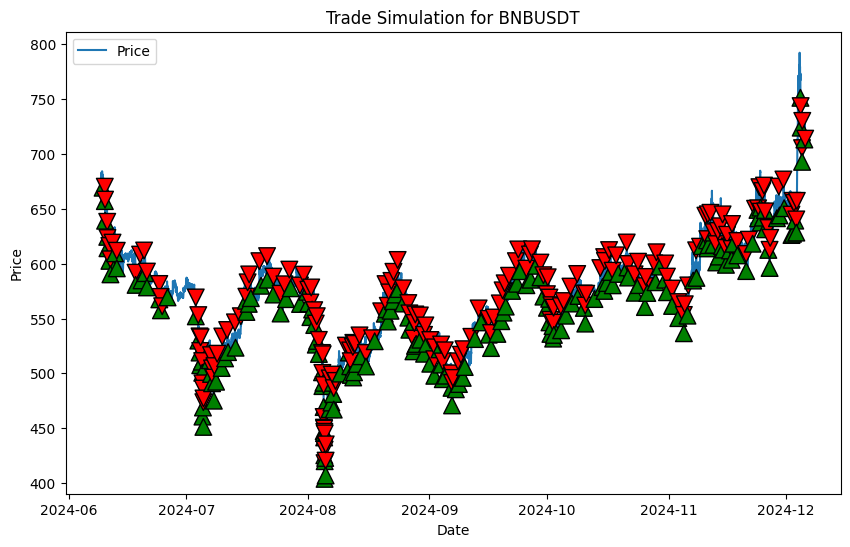

Buy/Sell Signals for BNBUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-09 15:45,676.9000,2024-06-10 05:15,662.6000,-14.3000
2024-06-10 05:30,664.7000,2024-06-10 06:45,650.8000,-13.9000
2024-06-10 07:00,646.8000,2024-06-10 20:00,630.6000,-16.2000
2024-06-10 20:15,632.1000,2024-06-10 21:15,615.8000,-16.3000
2024-06-10 21:30,621.7000,2024-06-11 09:15,608.6000,-13.1000
2024-06-11 09:30,610.2000,2024-06-11 15:30,596.4000,-13.8000
2024-06-11 15:45,597.9000,2024-06-12 04:30,611.6000,13.7000
2024-06-12 19:30,617.1000,2024-06-13 06:30,604.2000,-12.9000
2024-06-13 06:45,603.4000,2024-06-18 01:30,584.2000,-19.2000
2024-06-18 01:45,588.3000,2024-06-19 05:15,600.7000,12.4000


Visualizing RSI for BNBUSDT...


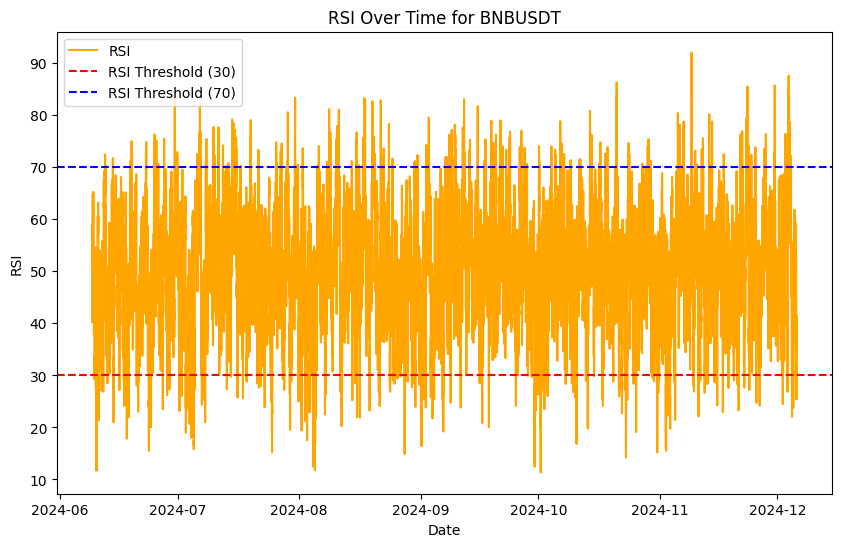

Processing DOGEUSDT...
Visualizing trades for DOGEUSDT...


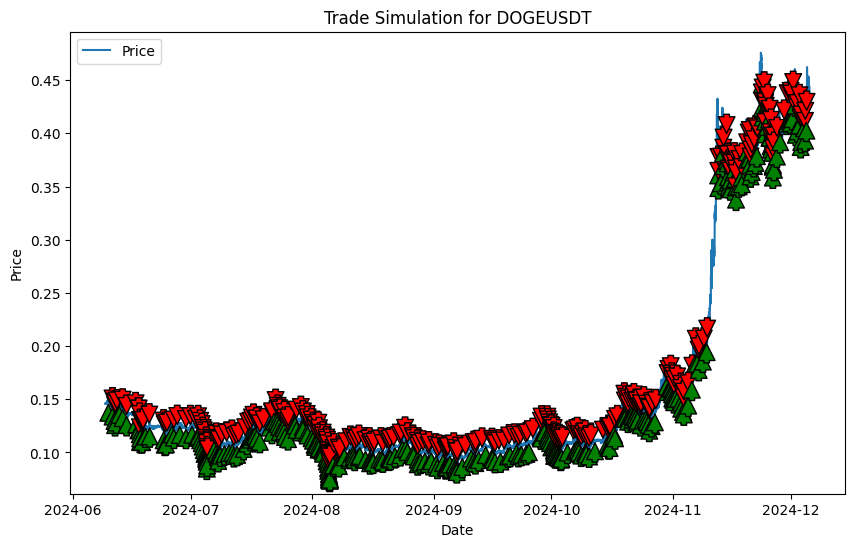

Buy/Sell Signals for DOGEUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 00:00,0.1461,2024-06-11 01:45,0.1419,-0.0042
2024-06-11 02:00,0.1425,2024-06-11 13:30,0.1389,-0.0036
2024-06-11 13:45,0.1384,2024-06-11 17:00,0.1356,-0.0028
2024-06-11 17:15,0.1345,2024-06-11 18:30,0.1374,0.0028
2024-06-12 00:45,0.1370,2024-06-12 04:30,0.1400,0.0030
2024-06-12 19:45,0.1441,2024-06-13 15:30,0.1408,-0.0033
2024-06-13 15:45,0.1411,2024-06-14 16:00,0.1349,-0.0062
2024-06-14 16:15,0.1346,2024-06-16 23:00,0.1373,0.0027
2024-06-17 02:15,0.1352,2024-06-17 13:45,0.1324,-0.0028
2024-06-17 15:45,0.1296,2024-06-17 18:00,0.1324,0.0028


Visualizing RSI for DOGEUSDT...


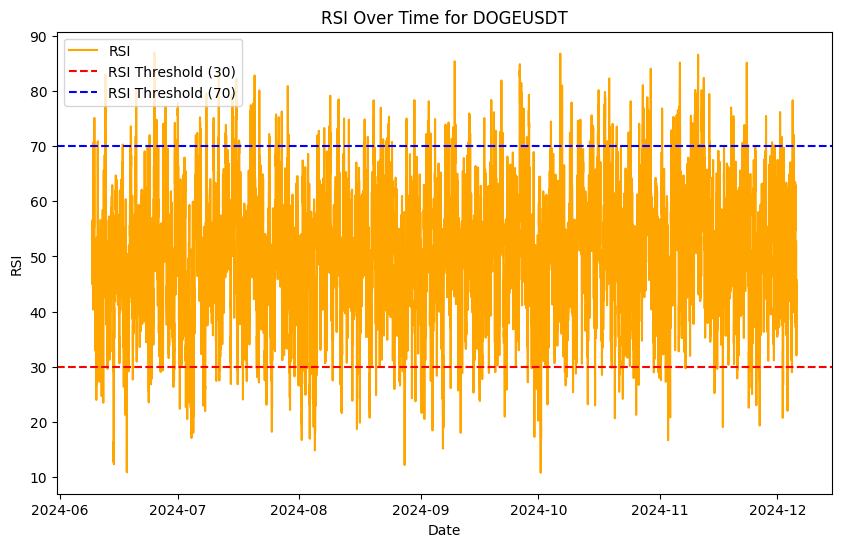

Processing ADAUSDT...
Visualizing trades for ADAUSDT...


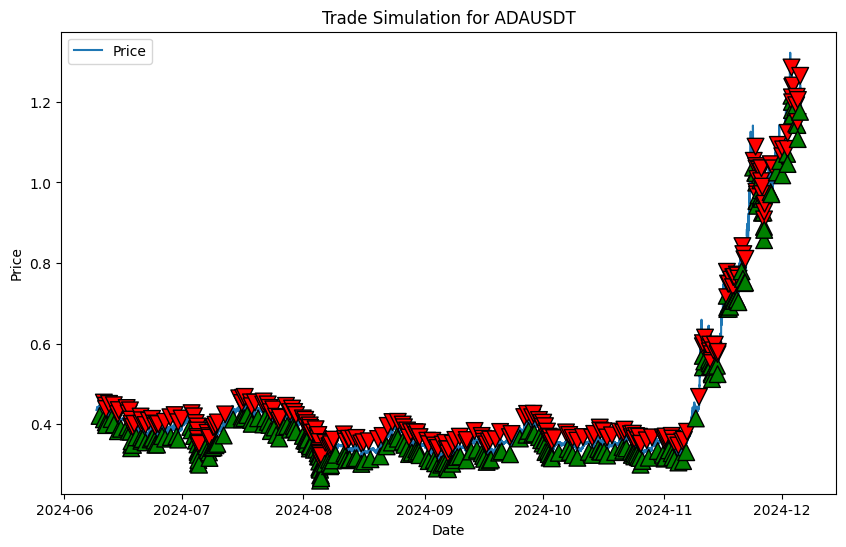

Buy/Sell Signals for ADAUSDT:


Buy Date,Buy Price,Sell Date,Sell Price,Profit
2024-06-10 00:00,0.4419,2024-06-11 02:15,0.4317,-0.0102
2024-06-11 02:30,0.4336,2024-06-11 13:45,0.4238,-0.0098
2024-06-11 14:00,0.4260,2024-06-11 15:30,0.4157,-0.0103
2024-06-11 15:45,0.4192,2024-06-12 10:00,0.4285,0.0093
2024-06-13 02:00,0.4342,2024-06-13 15:15,0.4252,-0.0090
2024-06-13 15:30,0.4209,2024-06-14 16:00,0.4031,-0.0178
2024-06-14 16:15,0.4040,2024-06-14 21:30,0.4130,0.0090
2024-06-15 11:00,0.4100,2024-06-16 22:00,0.4182,0.0082
2024-06-17 01:30,0.4139,2024-06-17 09:45,0.4048,-0.0091
2024-06-17 10:00,0.4032,2024-06-17 18:00,0.4124,0.0092


Visualizing RSI for ADAUSDT...


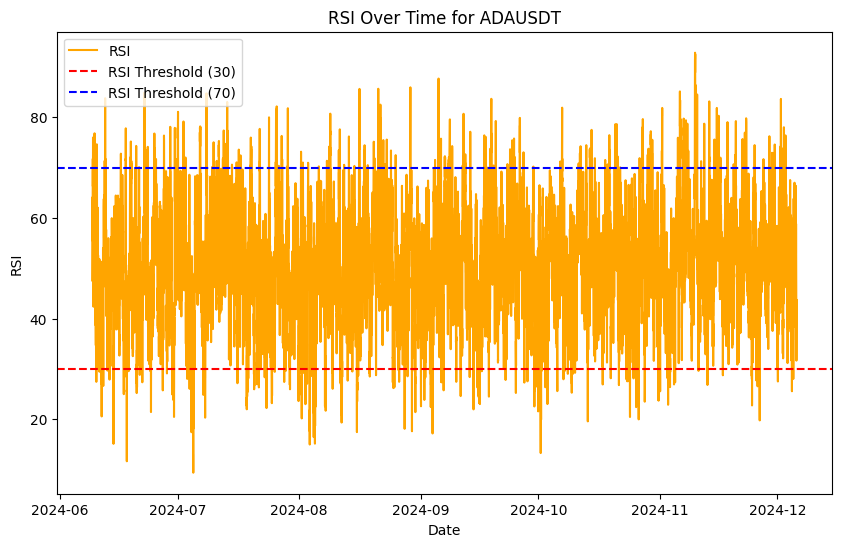

Backtesting Results for All Coins:


,total_trades,profitable_trades,total_profit,win_rate,coin
0,159,83,13619.27000,0.522013,BTCUSDT
1,207,111,394.84000,0.536232,ETHUSDT
2,240,135,1.05920,0.562500,XRPUSDT
3,289,150,34.91000,0.519031,SOLUSDT
4,196,103,-23.12000,0.525510,BNBUSDT
5,312,159,0.08773,0.509615,DOGEUSDT
6,270,142,0.18700,0.525926,ADAUSDT


In [132]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from datetime import datetime

# Global parameters (adjustable)
COINS = ["BTCUSDT", "ETHUSDT", "XRPUSDT", "SOLUSDT", "BNBUSDT", "DOGEUSDT", "ADAUSDT"]  # List of coins
INTERVAL = "15m"  # Data interval (e.g., "15m", "1h", "4h")
RSI_THRESHOLD = 40  # RSI threshold for buy signals
TAKE_PROFIT = 0.02  # Take profit level (3%)
STOP_LOSS = 0.02  # Stop loss level (1%)

def fetch_historical_data_complete(symbol, interval="15m", days=180):
    """Fetch historical crypto data from Binance."""
    from datetime import timedelta

    # Blacklist unwanted pairs
    blacklist = ["USDTUSDT", "STETHUSDT"]
    if symbol.upper() in blacklist:
        print(f"Symbol {symbol} ist geblacklistet. Überspringe...")
        return None
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(datetime.now().timestamp() * 1000)  # Current time in ms
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)  # Start time in ms

    all_data = []
    while start_time < end_time:
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000,
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            start_time = data[-1][6]
        else:
            print(f"Error fetching data for {symbol}: {response.status_code}")
            break

    df = pd.DataFrame(all_data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")
    df["Date"] = df["Open Time"]  # Add Date column for consistency
    df["Close"] = pd.to_numeric(df["Close"])  # Ensure numeric type for calculations

    return df[["Date", "Open", "Close", "High", "Low"]]



# Step 1: Calculate Indicators
def calculate_indicators(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates RSI, MACD, and Bollinger Bands.
    """
    data['RSI'] = RSIIndicator(data['Close'], window=14).rsi()
    macd = MACD(data['Close'], window_slow=26, window_fast=12, window_sign=9)
    data['MACD'] = macd.macd()
    data['Signal_Line'] = macd.macd_signal()
    bb = BollingerBands(data['Close'], window=20, window_dev=2)
    data['BB_Upper'] = bb.bollinger_hband()
    data['BB_Lower'] = bb.bollinger_lband()
    return data.dropna()


# Step 2: Simulate Trades
def simulate_trades_with_macd_bbands(data, rsi_threshold, take_profit, stop_loss, macd_threshold, bbands_condition):
    """
    Simulates trades based on RSI, MACD, and Bollinger Bands thresholds.
    """
    trades = []
    position = None

    for i in range(len(data)):
        price = data.iloc[i]['Close']
        rsi = data.iloc[i]['RSI']
        macd_diff = data.iloc[i]['MACD'] - data.iloc[i]['Signal_Line']
        price_bband_diff = data.iloc[i]['Close'] - data.iloc[i][bbands_condition]  # Upper or Lower BB

        # Entry condition
        if rsi < rsi_threshold and macd_diff > macd_threshold and price_bband_diff < 0 and position is None:
            position = {"entry_price": price, "entry_index": i}
            continue

        # Exit condition (take profit or stop loss)
        if position:
            entry_price = position['entry_price']
            if price >= entry_price * (1 + take_profit) or price <= entry_price * (1 - stop_loss):
                trades.append({
                    "entry_price": entry_price,
                    "exit_price": price,
                    "entry_index": position['entry_index'],
                    "exit_index": i,
                    "profit": price - entry_price,
                })
                position = None

    return trades



# Step 3: Evaluate Performance
def evaluate_performance(trades):
    """
    Evaluates the performance of the trading strategy.
    """
    total_trades = len(trades)
    profitable_trades = len([t for t in trades if t['profit'] > 0])
    total_profit = sum(t['profit'] for t in trades)
    win_rate = profitable_trades / total_trades if total_trades > 0 else 0
    return {
        "total_trades": total_trades,
        "profitable_trades": profitable_trades,
        "total_profit": total_profit,
        "win_rate": win_rate,
    }

# Step 4: Visualize Trades with Arrows

# Display Buy/Sell Signals in a formatted table
def display_signals_as_table(trades, data):
    """
    Formats and displays buy/sell signals in a visually appealing table.
    """
    # Format the trades into a list
    signal_list = []
    for trade in trades:
        entry_date = data.iloc[trade['entry_index']]['Date'].strftime("%Y-%m-%d %H:%M")  # Format to minutes
        entry_price = round(trade['entry_price'], 4)
        exit_date = data.iloc[trade['exit_index']]['Date'].strftime("%Y-%m-%d %H:%M")  # Format to minutes
        exit_price = round(trade['exit_price'], 4)
        profit = round(trade['profit'], 4)
        signal_list.append({
            "Buy Date": entry_date,
            "Buy Price": f"{entry_price:.4f}",
            "Sell Date": exit_date,
            "Sell Price": f"{exit_price:.4f}",
            "Profit": f"{profit:.4f}",
        })

    # Convert to DataFrame
    signal_df = pd.DataFrame(signal_list)

    # Use Pandas display method for better readability
    from IPython.display import display
    display(signal_df.style.set_properties(**{'text-align': 'center'}).hide(axis="index"))


# Update plot_trades_with_arrows to call the formatted table display
def process_all_coins_with_arrows_and_signals(coins):
    """
    Runs the backtesting pipeline for all specified coins with RSI visualization and improved charts.
    """
    results = []  # Store performance results
    for coin in coins:
        print(f"Processing {coin}...")

        # Step 1: Load historical data
        data = fetch_historical_data_complete(coin, INTERVAL, days=180)  # Use adjusted function
        if data is None or data.empty:
            print(f"No data for {coin}. Skipping...")
            continue

        # Step 2: Calculate indicators
        data = calculate_indicators(data)

        # Step 3: Simulate trades
        trades = simulate_trades(data, RSI_THRESHOLD, TAKE_PROFIT, STOP_LOSS)

        # Step 4: Evaluate performance
        performance = evaluate_performance(trades)
        performance["coin"] = coin  # Add coin name to results
        results.append(performance)

        # Step 5: Visualize trades and RSI
        print(f"Visualizing trades for {coin}...")
        plot_trades_with_arrows_and_table(data, trades, coin)
        print(f"Visualizing RSI for {coin}...")
        plot_rsi(data, coin)

    # Step 6: Summary of all coins
    results_df = pd.DataFrame(results)
    return results_df



# Step 5: Visualize RSI
def plot_rsi(data: pd.DataFrame, coin_name):
    """
    Plots the RSI over time for the given coin.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(data['Date'], data['RSI'], color='orange', label="RSI")
    plt.axhline(30, color='red', linestyle='--', label="RSI Threshold (30)")
    plt.axhline(70, color='blue', linestyle='--', label="RSI Threshold (70)")
    plt.title(f"RSI Over Time for {coin_name}")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend(loc="upper left")
    plt.show()


# Run the updated pipeline
results_df = process_all_coins_with_arrows_and_signals(COINS)

# Display the summary of results
print("Backtesting Results for All Coins:")
from IPython.display import display
display(results_df)


### Optimierung des Backtestings

In [133]:
import itertools

def optimize_strategy_for_winrate(data, rsi_range, take_profit_range, stop_loss_range, macd_range, bbands_range):
    """
    Optimizes the trading strategy to achieve the highest win rate by testing combinations of RSI, MACD, and Bollinger Bands thresholds.

    Parameters:
        data (pd.DataFrame): Historical price data with calculated indicators.
        rsi_range (list): List of RSI threshold values to test.
        take_profit_range (list): List of take profit values to test.
        stop_loss_range (list): List of stop loss values to test.
        macd_range (list): List of MACD thresholds (e.g., MACD - Signal Line) to test.
        bbands_range (list): List of Bollinger Bands conditions (e.g., price vs upper/lower band) to test.

    Returns:
        dict: Best parameter combination and corresponding performance metrics.
    """
    import itertools

    best_params = None
    best_performance = None
    highest_winrate = float('-inf')  # Initialize with a very low win rate

    # Generate all combinations of parameters
    parameter_combinations = list(itertools.product(rsi_range, take_profit_range, stop_loss_range, macd_range, bbands_range))

    for rsi_threshold, take_profit, stop_loss, macd_threshold, bbands_condition in parameter_combinations:
        # Simulate trades with the current parameter combination
        trades = simulate_trades_with_macd_bbands(data, rsi_threshold, take_profit, stop_loss, macd_threshold, bbands_condition)
        performance = evaluate_performance(trades)

        # Update the best parameters if this combination has a better win rate
        if performance["win_rate"] > highest_winrate:
            highest_winrate = performance["win_rate"]
            best_params = {
                "RSI Threshold": rsi_threshold,
                "Take Profit": take_profit,
                "Stop Loss": stop_loss,
                "MACD Threshold": macd_threshold,
                "Bollinger Bands Condition": bbands_condition,
            }
            best_performance = performance

    return {
        "Best Parameters": best_params,
        "Best Performance": best_performance,
    }



# Parameter ranges for optimization
RSI_RANGE = range(20, 61, 2)  # RSI thresholds from 20 to 60 in steps of 2
TAKE_PROFIT_RANGE = [0.01, 0.02, 0.03, 0.04, 0.05]  # Take profit levels from 1% to 5%
STOP_LOSS_RANGE = [0.01, 0.02, 0.03]  # Stop loss levels from 1% to 3%
MACD_RANGE = [0.0, 0.1, 0.2, 0.3, 0.4]  # MACD thresholds (MACD - Signal Line)
BBANDS_RANGE = ['BB_Upper', 'BB_Lower']  # Use Bollinger Bands upper or lower

# Optimize for a single coin
coin = "BTCUSDT"
data = fetch_historical_data_complete(coin, INTERVAL, days=180)
if data is not None and not data.empty:
    # Calculate indicators
    data = calculate_indicators(data)
    
    # Optimize for the highest win rate
    print(f"Optimizing strategy for highest win rate for {coin}...")
    optimization_result = optimize_strategy_for_winrate(data, RSI_RANGE, TAKE_PROFIT_RANGE, STOP_LOSS_RANGE, MACD_RANGE, BBANDS_RANGE)
    
    # Display the results
    print("Optimization Results:")
    print(f"Best Parameters for {coin}: {optimization_result['Best Parameters']}")
    print(f"Performance: {optimization_result['Best Performance']}")
else:
    print(f"No data available for {coin}.")


Optimizing strategy for highest win rate for BTCUSDT...


KeyboardInterrupt: 

### Dictionary

In [ ]:
# Parameterbereiche für die Optimierung
param_ranges = {
    "rsi_threshold": [20, 25, 30, 35, 40],  # RSI-Einstiegsschwellen
    "take_profit": [0.02, 0.03, 0.05],      # Gewinnziele
    "stop_loss": [0.01, 0.02, 0.03],        # Verlustgrenzen
    "trailing_stop_loss": [None, 0.02, 0.03]  # Dynamischer Stop-Loss
}

# Standardparameter für einfache Backtests
default_params = {
    "rsi_threshold": 30,       # Standardwert für RSI-Schwelle
    "take_profit": 0.03,       # Standardwert für Gewinnziel
    "stop_loss": 0.01,         # Standardwert für Verlustgrenze
    "trailing_stop_loss": 0.02 # Standardwert für Trailing Stop
}


#### Pipeline für mehrere Coins

In [ ]:
import os

def analyze_and_visualize_top_coins(blacklist, interval="15m", days=180):
    """
    Analysiert und visualisiert die Top 10 Coins (ausgenommen Blacklist).
    
    Parameters:
        blacklist (list): Liste der Coins, die ausgeschlossen werden sollen.
        interval (str): Zeitintervall für historische Daten.
        days (int): Zeitraum der historischen Daten in Tagen.
    """
    try:
        # Abrufen der Top 10 Coins
        coins = fetch_top_10_coins(blacklist)
        if coins is None or coins.empty:
            print("Fehler: Keine Coins gefunden. Abbruch.")
            return
        
        # Liste der Coins
        coin_symbols = coins['symbol'].tolist()
        print(f"Analysiere folgende Coins: {coin_symbols}")
        
        # Ergebnisordner erstellen, falls nicht vorhanden
        output_dir = "results"
        os.makedirs(output_dir, exist_ok=True)

        # Verarbeitung für jeden Coin
        for symbol in coin_symbols:
            print(f"\nStarte Analyse für {symbol}...")
            
            # Historische Daten abrufen oder laden
            data = fetch_or_load_historical_data(fetch_historical_data_complete, symbol, interval, days)
            if data is None or data.empty:
                print(f"Fehler: Keine historischen Daten für {symbol}. Überspringe.")
                continue
            
            # Indikatoren berechnen
            try:
                data = calculate_indicators(data)
                print(f"Indikatoren für {symbol} erfolgreich berechnet.")
            except Exception as e:
                print(f"Fehler bei der Berechnung der Indikatoren für {symbol}: {e}")
                continue
            
            # Backtesting durchführen
            try:
                params = {
                    "rsi_threshold": 30,
                    "take_profit": 0.03,
                    "stop_loss": 0.01,
                    "trailing_stop_loss": 0.02
                }
                trades, performance = simulate_long_trades(data, params)
                print(f"Backtesting für {symbol} abgeschlossen.")
                print(f"Performance: {performance}")
            except Exception as e:
                print(f"Fehler beim Backtesting für {symbol}: {e}")
                continue
            
            # Ergebnisse speichern
            try:
                data.to_csv(os.path.join(output_dir, f"{symbol}_data.csv"), index=False)
                trades.to_csv(os.path.join(output_dir, f"{symbol}_trades.csv"), index=False)
                print(f"Ergebnisse für {symbol} gespeichert.")
            except Exception as e:
                print(f"Fehler beim Speichern der Ergebnisse für {symbol}: {e}")
                continue
            
            # Visualisierung erstellen
            try:
                print(f"Erstelle Visualisierung für {symbol}...")
                plot_results(data, trades)
                print(f"Visualisierung für {symbol} abgeschlossen.")
            except Exception as e:
                print(f"Fehler bei der Visualisierung für {symbol}: {e}")
                continue

    except Exception as e:
        print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")


### Visualisierung der Ergebnisse

In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Vorhandener DataDict (enthält Daten für BTC, ETH, XRP)
# Das kommt von deinem vorherigen Schritt
# Beispiel:
# data_dict = {
#     "BTCUSDT": df_btc_with_indicators,
#     "ETHUSDT": df_eth_with_indicators,
#     "XRPUSDT": df_xrp_with_indicators,
#     "SOLUSDT": df_sol_with_indicators,
#     "BNBUSDT": df_bnb_with_indicators,
#     "DOGEUSDT": df_doge_with_indicators,
#     "ADAUSDT": df_ada_with_indicators
# }

# Liste der Indikatoren, die geplottet werden sollen
indicators_to_plot = ['BB_Upper', 'BB_Lower', 'BB_Middle', 'RSI', 'MACD', 'MACD_Signal']

# Dash-App initialisieren
app = dash.Dash(__name__)

# Layout der App mit Tabs für mehrere Coins
app.layout = html.Div([
    html.H1("Krypto-Visualisierung für mehrere Coins"),
    dcc.Tabs(
        id='coin-tabs',
        value=list(data_dict.keys())[0],  # Standard-Tab (erster Coin)
        children=[
            dcc.Tab(label=coin, value=coin) for coin in data_dict.keys()
        ]
    ),
    dcc.Graph(
        id='crypto-plot',
        config={'scrollZoom': True},  # Aktiviert das Zoomen
        style={'height': '2000px', 'width': '100%'}  # Vergrößert das Fenster
    )
])

# Callback für die Aktualisierung des Plots basierend auf dem ausgewählten Tab
@app.callback(
    Output('crypto-plot', 'figure'),
    Input('coin-tabs', 'value'),  # Aktiver Tab (Coin)
    Input('crypto-plot', 'relayoutData')  # Benutzerinteraktion für Zoom
)
def update_graph(selected_coin, relayout_data):
    # Hole die Daten für den ausgewählten Coin
    data = data_dict[selected_coin]

    # Farben für Indikatoren
    colors = px.colors.qualitative.Set2
    color_mapping = {ind: colors[i % len(colors)] for i, ind in enumerate(indicators_to_plot)}

    # Anzahl der Subplots
    rows = 1 + len(indicators_to_plot)
    fig = make_subplots(
        rows=rows,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.5] + [0.5 / len(indicators_to_plot)] * len(indicators_to_plot)
    )

    # Preis-Chart
    fig.add_trace(
        go.Scatter(
            x=data['open time'],
            y=data['close'],
            mode='lines',
            name='Close Price',
            line=dict(color='blue')
        ),
        row=1, col=1
    )

    # Bollinger-Bänder hinzufügen
    for ind in ['BB_Upper', 'BB_Lower', 'BB_Middle']:
        if ind in data.columns:
            fig.add_trace(
                go.Scatter(
                    x=data['open time'],
                    y=data[ind],
                    mode='lines',
                    name=ind,
                    line=dict(dash='dash', color=color_mapping[ind])
                ),
                row=1, col=1
            )

    # Indikatoren hinzufügen
    for i, ind in enumerate(indicators_to_plot):
        if ind in data.columns:
            fig.add_trace(
                go.Scatter(
                    x=data['open time'],
                    y=data[ind],
                    mode='lines',
                    name=ind,
                    line=dict(color=color_mapping[ind], dash='dot')
                ),
                row=i + 2, col=1
            )
            # Beschriftung rechts
            fig.update_yaxes(title_text=ind, row=i + 2, col=1, side='right')

    # Bereichsbeschränkung für sichtbare Daten
    x_min, x_max = None, None
    if relayout_data:
        # Überprüfe auf Benutzer-Zoom (X- und Y-Achsen manuell angepasst)
        user_zoom_x = 'xaxis.range[0]' in relayout_data and 'xaxis.range[1]' in relayout_data
        user_zoom_y = 'yaxis.range[0]' in relayout_data or 'yaxis.range[1]' in relayout_data

        if user_zoom_x:
            # Verwende Benutzer-Zoom für X-Achse
            x_min, x_max = relayout_data['xaxis.range[0]'], relayout_data['xaxis.range[1]']
        else:
            # Standardbereich
            x_min, x_max = data['open time'].min(), data['open time'].max()

        # Nur skalieren, wenn die Y-Achse nicht manuell angepasst wurde
        if not user_zoom_y:
            # Filtere sichtbare Daten
            visible_data = data[(data['open time'] >= x_min) & (data['open time'] <= x_max)]

            # Dynamische Y-Achsen-Anpassung
            fig.update_yaxes(range=[visible_data['close'].min(), visible_data['close'].max()], row=1, col=1)
            for i, ind in enumerate(indicators_to_plot):
                if ind in visible_data.columns:
                    fig.update_yaxes(
                        range=[visible_data[ind].min(), visible_data[ind].max()],
                        row=i + 2, col=1
                    )

    # Layout-Optionen
    fig.update_layout(
        title=f"Krypto-Preis und Indikatoren für {selected_coin}",
        height=2000,
        template="plotly_white",
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    return fig


# App starten
if __name__ == '__main__':
    app.run_server(debug=True)
